<a href="https://colab.research.google.com/github/AgoMilan/Ai/blob/main/01_hledej_sperk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -Uqq fastai duckduckgo_search
!pip install fastbook
!pip install fastai

Dvě třídy
1. Předpovídá do které kategorie patří testovaný obrazek.
2. Vyhledá v předpovězené kategorii stejný nebo nejpodobnější obrázek

Obrázek 'obr_1.jpg' klasifikován jako 'ring' a zkopírován do '/content/drive/MyDrive/Katalog/sperk/ring'
Porovnat v kategorii -  ring


Cesta k hledanému obrázku - /content/drive/MyDrive/Katalog/sperk/ring/ring_129.jpg


Cesta k hledanému obrázku - /content/drive/MyDrive/Katalog/sperk/ring/ring_2.jpg


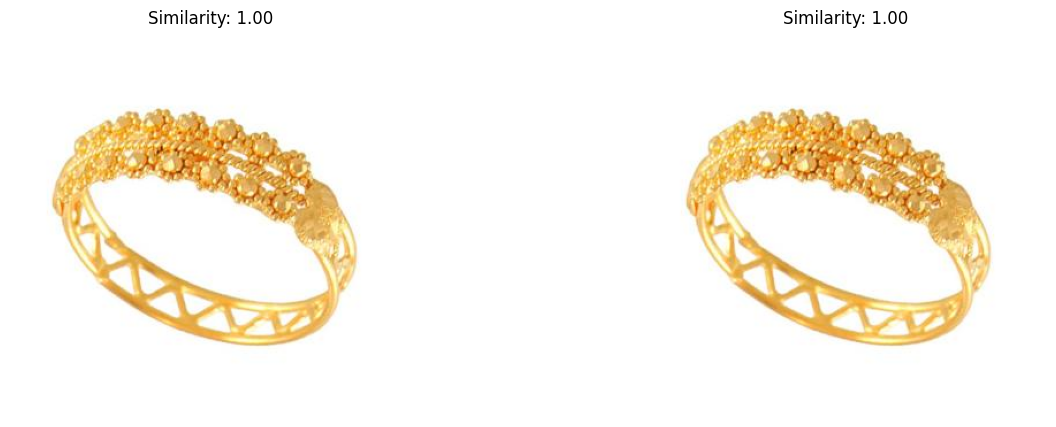

In [23]:
from fastai.vision.all import *
from pathlib import Path
import shutil
from scipy.spatial.distance import cosine
import os
from PIL import Image

##Třída předpovídá do které kategorie patří testovaný obrázek
class ImageClassifier:
    def __init__(self, model_dir, classified_dir, class_mapping):
        self.model_dir = Path(model_dir)
        self.classified_dir = Path(classified_dir)
        self.class_mapping = class_mapping
        self.learn_predict = load_learner(self.model_dir/'model.pkl')

    def classify_and_copy(self, image_path):
        img = PILImage.create(image_path)
        pred, label, probs = self.learn_predict.predict(img)

        label_str = self.class_mapping[str(label)]
        target_dir = self.classified_dir / label_str
        target_path = target_dir / image_path.name

        if target_path.exists():
            print(f"Soubor '{image_path.name}' již existuje v cílovém adresáři '{target_dir}'. Přeskočeno.")
            return

        #shutil.copy(image_path, target_path)

        print(f"Obrázek '{image_path.name}' klasifikován jako '{label_str}' a zkopírován do '{target_dir}'")
        print("Porovnat v kategorii - ", label_str)
        self.spust_porovnej_obr(target_dir)

    def process_images(self, unclassified_dir):
        for label_dir in unclassified_dir.glob("*"):
            if label_dir.is_dir():
                for image_path in get_image_files(label_dir):
                    self.classify_and_copy(image_path)

    def spust_porovnej_obr(self, kategorie):
        # Parametry třídy
        model_dir = "/content/drive/MyDrive/Katalog"
        test_image_path = "/content/drive/MyDrive/KatalogAA/Sperky/obr_1.jpg"
        #similar_images_path = "/content/drive/MyDrive/Katalog/sperk/mensRing"
        similar_images_path = kategorie
        threshold = 0.95

        # Vytvoření instance třídy
        image_similarity_classifier = ImageSimilarityClassifier(model_dir, test_image_path, similar_images_path, threshold)

        # Zobrazení podobných obrázků s názvy souborů
        image_similarity_classifier.display_similar_images()



##Třída testuje podobnost s obrázkem v předpovězené kategorii
class ImageSimilarityClassifier:
    def __init__(self, model_path, test_image_path, similar_images_path, threshold=0.95):
        # Inicializace třídy s cestami k modelu, testovacímu obrázku a složce s podobnými obrázky
        self.model_path = Path(model_path)
        self.test_image_path = Path(test_image_path)
        self.similar_images_path = Path(similar_images_path)
        self.threshold = threshold

        # Definice DataLoaderů pro podobné obrázky
        self.dls = DataBlock(
            blocks=(ImageBlock, CategoryBlock),
            get_items=get_image_files,
            splitter=RandomSplitter(valid_pct=0.2, seed=42),
            get_y=parent_label,
            item_tfms=[Resize(192, method='squish')]
        ).dataloaders(self.similar_images_path, bs=30)

        # Načtení modelu pro predikci
        self.learn = load_learner(self.model_path / 'model.pkl')

        # Vybrání konkrétní vrstvy modelu pro extrakci rysů
        self.target_layer = self.learn.model[0][-2][0]

        # Registrování hook funkce na vybrané vrstvě
        self.hook = self.target_layer.register_forward_hook(self.hook_fn)
        self.hook_output = None

    def hook_fn(self, m, i, o):
        # Hook funkce pro extrakci výstupu z vrstvy
        self.hook_output = o

    def load_test_image(self):
        # Načtení testovacího obrázku
        return PILImage.create(self.test_image_path)

    def extract_feature_vector(self, img):
        # Extrakce vektoru rysů z obrázku
        with torch.no_grad():
            self.learn.predict(img)
        return self.hook_output[0].view(-1)

    def calculate_similarity(self, vector1, vector2):
        # Výpočet kosínové podobnosti mezi dvěma vektory
        return 1 - cosine(vector1, vector2)

    def find_similar_images(self):
        # Hledání podobných obrázků
        feature_vector = self.extract_feature_vector(self.load_test_image())
        similar_images = []

        for img_path in get_image_files(self.similar_images_path):
            img = PILImage.create(img_path)
            ring_feature_vector = self.extract_feature_vector(img)
            similarity = self.calculate_similarity(feature_vector, ring_feature_vector) #hodnota podobnosti
            if similarity >= self.threshold:
                print("Cesta k hledanému obrázku -",img_path)
                similar_images.append((img, similarity))

        similar_images.sort(key=lambda x: x[1], reverse=True)
        # Získání názvu obrázku z cesty souboru
        #similar_image_name = os.path.basename(similar_images[0][0].filename)
        #print(similar_image_name)
        return similar_images

    def display_similar_images(self, num_similar=5):
        # Zobrazení podobných obrázků s názvy souborů
        similar_images = self.find_similar_images()
        num_similar = min(num_similar, len(similar_images))
        fig, axes = plt.subplots(1, num_similar, figsize=(15, 5))


        for i in range(num_similar):
            img, similarity = similar_images[i]
            ax = axes[i]
            #img_path = str(img)  # Převod Path objektu na řetězec
            #img_name = os.path.basename(img_path)  # Získání názvu souboru
            #img.show(ax=ax, title=f"Name: {img_name}\nSimilarity: {similarity:.2f}")
            img.show(ax=ax, title=f"Similarity: {similarity:.2f}")
            ax.axis('off')

        plt.show()

# Definice cest k adresářům
unclassified_dir = Path("/content/drive/MyDrive/KatalogAA")
classified_dir = Path("/content/drive/MyDrive/Katalog/sperk")
model_dir = Path("/content/drive/MyDrive/Katalog/")

# Mapování mezi interními názvy tříd a požadovanými názvy adresářů
class_mapping = {
    'tensor(0)': 'earring',
    'tensor(1)': 'chain',
    'tensor(2)': 'childrensEarring',
    'tensor(3)': 'mensRing',
    'tensor(4)': 'necklace',
    'tensor(5)': 'pendant',
    'tensor(6)': 'ring',
    'tensor(7)': 'weddingRing'
}

# Vytvoření instance ImageClassifier a zpracování obrázků
image_classifier = ImageClassifier(model_dir, classified_dir, class_mapping)
image_classifier.process_images(unclassified_dir)